<a href="https://colab.research.google.com/github/aleks-haksly/Postypashka/blob/main/DA/02%20HW_lab/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Подготовка данных для анализа

1. Скачаем реестр анализируемых компаний
2. Прочитаем Excel файл и создадим из него DataFrame. Считывать будем только колонки, которые будут использоваться в дальнейших расчетах показателя
[EBITDA](https://xn--80aapampemcchfmo7a3c9ehj.xn--p1ai/news/chto-takoe-ebitda/)


In [ ]:
# файл Реестр.xlsx для обработки
!wget "https://github.com/aleks-haksly/Postypashka/raw/refs/heads/main/DA/02%20HW_lab/%D0%A0%D0%B5%D0%B5%D1%81%D1%82%D1%80.xlsx" -q
# файл reestr_filtered.xlsx - результат обработки при подготовке данных
!wget "https://github.com/aleks-haksly/Postypashka/raw/main/DA/02%20HW_lab/reestr_filtered.xlsx" -q

In [ ]:
df_reestr = pd.read_excel("/content/Реестр.xlsx", header = 2, usecols=[1, 2, 3, 5, 6, 7, 9]) # nrows=1000

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df_reestr.head(5)

,Наименование / ФИО,Тип субъекта,Категория,ИНН,Основной вид деятельности,Регион,Город
0,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN
1,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN
2,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,5263039399,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,г Нижний Новгород
3,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,5263025484,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,г Нижний Новгород
4,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,7801123215,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN


3. Отфильтруем DataFrame и сохраним его копию, содержащую данные отвечающие всем условиям:
* Юридическое лицо
* Среднее предприятие либо Малое предприятие
* Основной вид деятельности - "41.20 Строительство жилых и нежилых зданий"

In [ ]:
df_reestr = df_reestr.query("(`Категория` in ('Среднее предприятие', 'Малое предприятие')) & \
                             (`Основной вид деятельности` == '41.20 Строительство жилых и нежилых зданий') &\
                             (`Тип субъекта` == 'Юридическое лицо')")[['Наименование / ФИО', 'Регион', 'Город', 'Категория', 'ИНН']]

In [ ]:
df_reestr.to_excel("reestr_filtered.xlsx", index=False)

# Парсинг данных

Парсинг будет состоять из 2 этапов:
1. Для кажого предприятия, находящегося в нашем DataFrame мы по ИНН получим его внутренний `id` сайта nalog.ru
2. Используя найденные `id` мы выгрузим и аггрегируем ифнормацию об изменени **EBITDA** компаний во времени

## Этап 1 - получения внтренних id компаний

In [ ]:
df_reestr = pd.read_excel("reestr_filtered.xlsx", index_col=[0])
df_reestr.head()

,Наименование / ФИО,Регион,Город,Категория,ИНН
19,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838
51,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369
4652,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922
4667,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",33 - Владимирская область,г Владимир,Малое предприятие,3327332190
4673,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",78 - г.Санкт-Петербург,NaN,Малое предприятие,7816061297


In [ ]:
# сохраним все ИНН в список
inns = df_reestr['ИНН'].to_list()

In [ ]:
# для парсинг будем использовать cсессию с заголовком, маскирующим нас под браузер
session = requests.Session()

headers ={'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.28 Safari/537.36'}

session.headers = headers
session.timeo0ut = 6

In [ ]:
# напишем функцию для парсинга id компаний по их ИНН
def inn_to_id(inn:str, session:requests.Session=session)->str:
    try:
        response = session.get(f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0")
        if response.status_code == 200:
            content = response.json().get("content", None)
            if isinstance(content, list):
                id = content[0].get('id', None)
                if not id:
                    print(f"По ИНН {inn} данные не найдены.")
                return (inn, id)
            return (inn, None)
        else:
            print(f"Ошибка запроса: {response.status_code}")
            return (None, None)
    except requests.exceptions.RequestException as e:
        print(f"Ошибка соединения: {e}")
        return (None, None)

In [ ]:
# создадим файл, куда будем сохранять результаты парсинга id
with open('company_ids.json', 'w') as file:
    json.dump([['inn', 'id']], file)

In [ ]:
# основной цикл 1 части программы - парсим и сохраняем (ИНН, id) организаций в файл company_ids.json
s = 60 # таймаут в случае, если сервер сбрасывает подключение
while len(inns) > 0: #пока остались необработанные ИНН
    ids = json.load(open('company_ids.json', 'r'))
    inns = set(inns) - set(id[0] for id in ids) # убираем из множества ИНН те, для которых уже получен id
    print(f"Осталось обработать {len(inns)} ИНН")
    for inn in tqdm(inns):
        sleep(0.5)
        id = inn_to_id(inn, session)
        if not any(id): # если была ошибка подключения или сервер не вернул данные как следует
            # для сериализации данных по ИНН - id и сохранению в файл
            with open('company_ids.json', 'w') as file:
                json.dump(ids, file)
            print(f'Жду {s} секунд и пробую продолжить')
            sleep(s)
            break
        ids.append(id)

with open('company_ids.json', 'w') as file:
                json.dump(ids, file)

## Этап 2 - получение данных о финансовых показателях компаний

Коды строк в формах бухгалтерской отчетности, указываемые в годовой бухгалтерской отчетности организации, представляемой в органы государственной статистики и другие органы исполнительной власти
1. Чистая прибыль (убыток) 2400
  
2. Налог на прибыль 2410
  
3. Проценты по долговым обязательствам  2330
  
4. Амортизация 1210 (1190)

6. Выручка 2110

In [ ]:
# файл company_ids.json - результат парсинга этапа 1
!wget "https://raw.githubusercontent.com/aleks-haksly/Postypashka/refs/heads/main/DA/02%20HW_lab/company_ids.json" -q

In [ ]:
# функция для преобразование строк в float
def str_to_float(s: str) -> float:
    try:
        return float(s)
    except (TypeError, ValueError):
        return 0

In [ ]:
# напишем функцию для парсинга финансовых показателей и расчета EBITDA
def ebitda_calc(id:str, session:requests.Session=session, revenue_year=2023):
    EBITDA = {'id': id}
    try:
        response = session.get(f"https://bo.nalog.ru/nbo/organizations/{id}/bfo")
        if response.status_code == 200:
            for year_data in response.json():
                year = year_data.get('period', None)
                financialResult = year_data.get('correction', dict()).get('financialResult', None)
                balance = year_data.get('correction', dict()).get('balance', None)
                if isinstance(financialResult, dict) and isinstance(balance, dict):
                    profit = financialResult.get('current2400', None)
                    taxes = financialResult.get('current2410', None)
                    interest = financialResult.get('current2330', None)
                    depreciation = balance.get('current1210', None)
                    revenue = financialResult.get('current2110', None)
                #if all([year, profit, taxes, interest, depreciation]):
                try:
                    EBITDA.update({year: sum(map(str_to_float, [profit, taxes, interest, depreciation]))})
                except TypeError:
                    EBITDA.update({year: None})
                if year == str(revenue_year):
                    EBITDA.update({'revenue': revenue})

        else:
            print(f"Ошибка запроса: {response.status_code}")
            return dict()
        return EBITDA
    except requests.exceptions.RequestException as e:
        print(f"Ошибка соединения: {e}")
        return dict()

In [ ]:
# создадим файл EBITDA.json, куда будем сохранять данные о финансовых показателях компаний
with open('EBITDA.json', 'w') as file:
    json.dump([{}], file)

In [ ]:
# получим список всех id компаний
ids = set(data[1] for data in json.load(open('company_ids.json', 'r')))

In [ ]:
# основной цикл 2 частипрограммы, где мы получаем данные о финансовых показателях и сохраняем в файл EBITDA.json
s = 60 # таймаут в случае, если сервер сбрасывает подключение
while len(ids) > 0: #пока остались необработанные id
    EBITDA = json.load(open('EBITDA.json', 'r'))
    ids = ids - set(EBITDA.get('id', None) for EBITDA in EBITDA) # убираем из множества id те, для которых уже получена EBITDA
    print(f"Осталось обработать {len(ids)} id")
    for id in tqdm(ids):
        sleep(0.5)
        EBITDA_data = ebitda_calc(id, session)
        if not EBITDA_data.get('id', None): # если была ошибка подключения или сервер не вернул данные как следует
            # для сериализации данных и сохранению в файл
            with open('EBITDA.json', 'w') as file:
                json.dump(EBITDA, file)
            print(f'Жду {s} секунд и пробую продолжить')
            sleep(s)
            break
        EBITDA.append(EBITDA_data)
    with open('EBITDA.json', 'w') as file:
        json.dump(EBITDA, file)


In [ ]:
with open('EBITDA.json', 'w') as file:
        json.dump(EBITDA, file)

# Анализ данных
Скачаем в рабочую директорию полученные на предыдущих этапах файлы

In [2]:
# файл reestr_filtered.xlsx - результат обработки при подготовке данных
!wget "https://github.com/aleks-haksly/Postypashka/raw/main/DA/02%20HW_lab/reestr_filtered.xlsx" -q

In [3]:
# файл company_ids.json - результат парсинга этапа 1
!wget "https://raw.githubusercontent.com/aleks-haksly/Postypashka/refs/heads/main/DA/02%20HW_lab/company_ids.json" -q

In [81]:
# файл EBITDA.json - результат парсинга этапа 2
!wget "https://raw.githubusercontent.com/aleks-haksly/Postypashka/refs/heads/main/DA/02%20HW_lab/EBITDA.json" -q

Превратим полученные данные в DataFrame

In [3]:
df_ebitda = pd.DataFrame.from_records(json.load(open('EBITDA.json', 'r'))[1:])
# для наглядности отсортируем колонки
ordered_columns = sorted(df_ebitda.columns.to_list(),\
                         key=lambda x: x if '_' in x else ' ' + x)
df_ebitda = df_ebitda[ordered_columns]
df_ebitda.head(3)

,id,ebitda_2019,ebitda_2020,ebitda_2021,ebitda_2022,ebitda_2023,net_profit_2019,net_profit_2020,net_profit_2021,net_profit_2022,net_profit_2023
0,8617989,28618.0,33923.0,53279.0,23265.0,30588.0,7378.0,15976.0,28549.0,9400.0,8928.0
1,6225927,4084.0,745.0,338.0,546.0,465.0,283.0,443.0,417.0,506.0,533.0
2,3964947,11375.0,23754.0,54565.0,20211.0,23332.0,4543.0,18216.0,43309.0,15530.0,7887.0


In [4]:
df_reestr = pd.read_excel("reestr_filtered.xlsx" )
df_reestr.head(3)

,Наименование / ФИО,Регион,Город,Категория,ИНН
0,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838
1,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922


In [5]:
ids = json.load(open('company_ids.json', 'r'))
df_ids = pd.DataFrame(ids, columns=['ИНН', 'id']).dropna().astype({"ИНН": "Int64", "id": "Int64"})
df_ids.head(3)

,ИНН,id
0,5038038838,5872486
1,5027006369,6900709
2,1414006922,4980670


Финальный DataFrame содержащий данные о показателе EBITDA по годам для каждого предприятия:

In [6]:
#объединим данные в одну таблицу
data = df_reestr.merge(df_ids, how='left', on='ИНН')\
                .merge(df_ebitda, how='left', on='id').drop_duplicates(subset='id')
data.head(5)

,Наименование / ФИО,Регион,Город,Категория,ИНН,id,ebitda_2019,ebitda_2020,ebitda_2021,ebitda_2022,ebitda_2023,net_profit_2019,net_profit_2020,net_profit_2021,net_profit_2022,net_profit_2023
0,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",50 - Московская область,NaN,Малое предприятие,5038038838,5872486,598067.0,324491.0,253774.0,227785.0,184000.0,-20438.0,-8543.0,3080.0,19518.0,-20913.0
1,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",50 - Московская область,г Дзержинский,Среднее предприятие,5027006369,6900709,98555.0,242052.0,170427.0,194676.0,573989.0,28242.0,29618.0,20376.0,31442.0,582441.0
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",77 - г.Москва,NaN,Малое предприятие,1414006922,4980670,144701.0,187477.0,658544.0,742527.0,1006553.0,1386.0,-5382.0,2092.0,3375.0,19889.0
3,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",33 - Владимирская область,г Владимир,Малое предприятие,3327332190,3867230,77523.0,85031.0,55620.0,65146.0,112194.0,12154.0,18957.0,20565.0,30374.0,40101.0
4,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",78 - г.Санкт-Петербург,NaN,Малое предприятие,7816061297,7041303,36732.0,35867.0,4333.0,5725.0,20649.0,12293.0,5273.0,1077.0,444.0,565.0


In [7]:
def replace_extreme_quantiles(col, lower_quantile=0.01, upper_quantile=0.99):
    '''
     Функция вычисляет значения верхнего и нижнего квантиля из значений в колонке col
     и заменяет выбросы на значения соответствующих квантилей
    '''
    quantile_01 = col.quantile(lower_quantile)
    quantile_99 = col.quantile(upper_quantile)

    return col.apply(lambda x: quantile_01 if x < quantile_01 else (quantile_99 if x > quantile_99 else x))

In [8]:
def hist_plot(df, title, xlabel="Изменение относительно предыдущего года, %", dropna_subset=None, ylabel="Количество", log_scale=True):
    '''
    Функция строит гистограмму распределения процентного изменения значений в колонках, при этом выбросы заменяются на квантили 1% и 99%,
    пропуски в данных удаляются в колонках dropna_subset
    '''
    dropna_subset = dropna_subset or []
    df.iloc[:,2:].dropna(thresh=5)\
      .pct_change(axis=1)\
      .replace([np.inf, -np.inf], np.nan)\
      .apply(replace_extreme_quantiles, axis=0).iloc[:,1:]\
      .plot(kind='hist',\
            subplots=True,\
            bins=int(data.shape[0]**.5),\
            figsize=(8, 8),\
            log=log_scale,\
            sharex=False,\
            edgecolor='black',
            title=title,
            ylabel=ylabel,\
            xlabel=xlabel);

In [9]:
def box_plot_with_cat(df, title, stubnames='ebitda_', ylabel="Изменение, %"):
    '''
    Функция строит boxplot распределения процентного изменения значений в колонках, при этом выбросы заменяются на квантили 1% и 99%,
    пропуски в данных удаляются в колонках dropna_subset
    '''

    df_2 = df.iloc[:,2:].dropna(thresh=5)\
               .pct_change(axis=1, )\
               .replace([np.inf, -np.inf], np.nan).iloc[:,1:]

    df_2 = df_2.merge(df[['Категория', 'id']], left_index=True, right_index=True)
    df_3 = pd.wide_to_long(df_2, stubnames=stubnames, i=['id', 'Категория'], j='Год')
    sns.set_style("whitegrid")
    sns.catplot(data=df_3, x='Год', y=stubnames, kind='box', hue='Категория', showfliers=False).set(ylabel='Изменение, %', title=title)


### Определим, насколько перспективна отрасль строительства жилых и нежилых заний в настоящее время путем анализ изменения показателя EBITDA компаний

In [10]:
df_with_category = data[['id', 'Категория', 'ebitda_2019',	'ebitda_2020',	'ebitda_2021',	'ebitda_2022',	'ebitda_2023']].drop_duplicates(subset='id')

Построим гистограмму процентного изменения показателя EBITDA

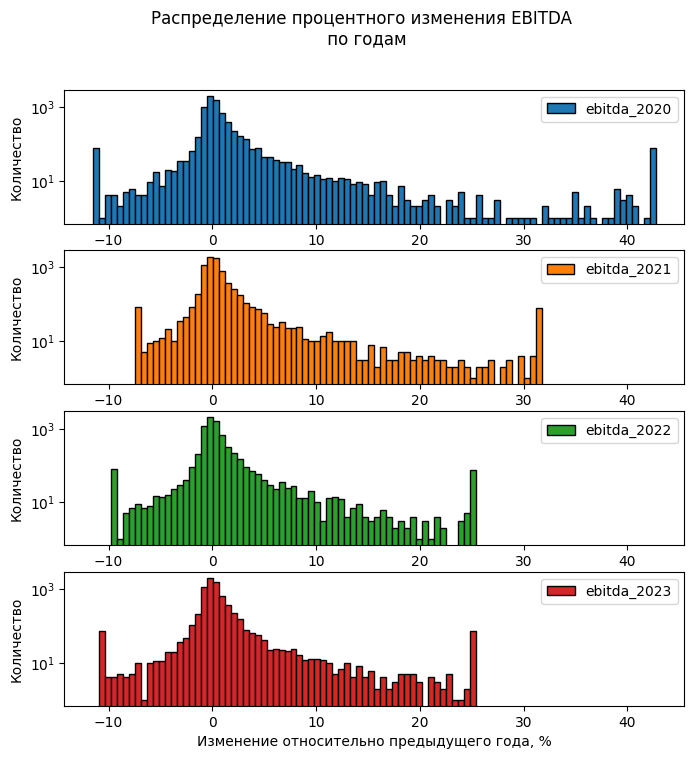

In [11]:
hist_plot(df_with_category, title="Распределение процентного изменения EBITDA \n по годам")

При интерпретации необходимо учитывать, что шкала частот прологарифмирована для наглядности, выбросы ниже 0.01 и свыше 0.99 заменены значениями соответствующих квантилей.

На графиках наблюдается некоторое снижение роста EBITDA начиная с 2021 года.

Продолжим исследование используя график boxplot.

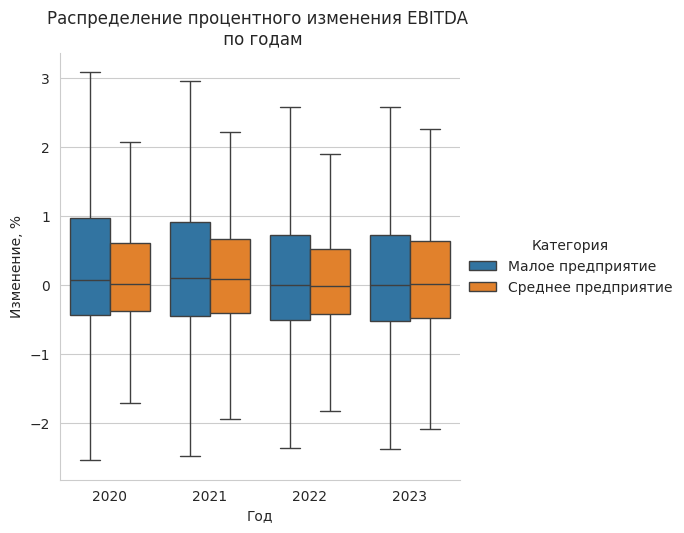

In [15]:
box_plot_with_cat(df_with_category, stubnames='ebitda_', title="Распределение процентного изменения EBITDA \n по годам")

На графике выше видно, что до 2022 года большая часть предприятий в отрасли показывали незначительный рост EBITDA. При этом немного чаще рост наблюдался в категории малых предприятий. Начиная с 2022 года рост в среднем прекратился в обоеих категриях. Возможно, это связано со сложностями с получением импортных материалов из-за санкций и отключением SWIFT.

Посмотрим на численные значения по квантилям.

In [16]:
df_with_category.iloc[:, 2:].dropna(thresh=5).pct_change(axis=1).replace([np.inf, -np.inf], np.nan).iloc[:,1:].describe()

,ebitda_2020,ebitda_2021,ebitda_2022,ebitda_2023
count,7406.000000,7445.000000,7433.000000,7404.000000
mean,-11.635715,0.563501,16.156695,0.773790
std,1603.964751,105.716456,1455.239679,35.933963
min,-135567.500000,-7124.965616,-14290.400000,-1590.500000
25%,-0.434063,-0.440227,-0.507360,-0.516550
50%,0.069504,0.097586,0.002161,0.005254
75%,0.935381,0.894433,0.702814,0.715394
max,19552.000000,2520.224490,124331.210526,1486.896057


Видим, что медианное значение (50%) в 2022, 2023 годах почти не отличается от 0 только, что говорит о том, что дела в отрасли идут не слишком хорошо. Средние значения, ввиду сильных выбросов, не рассматриваем.


Чтобы удостовериться в наличии изменения между 2021 и 2022 годами, проведем статистический тест, используя U-критерий Манна — Уитни c поправкой на эффект множественных сравнений Бонферрони.

In [17]:
from scipy.stats import mannwhitneyu

In [18]:
test_data = df_with_category.iloc[:,2:].dropna(thresh=5)\
                                       .pct_change(axis=1)\
                                       .replace([np.inf, -np.inf], np.nan).iloc[:,1:]

In [19]:
alpha = 0.05
alpha_bonferroni = alpha / (test_data.shape[1] - 1)
print(f'Статистически значимая разница на уровне значимости {alpha_bonferroni:.1%}:')
for start_year, end_year in zip(test_data.columns[:-1], test_data.columns[1:]):
    t_stat, p_val = mannwhitneyu(test_data[start_year].dropna(), test_data[end_year].dropna())
    print([f'между {start_year.split("_")[-1]} и {end_year.split("_")[-1]} годами',\
           f'между {start_year.split("_")[-1]} и {end_year.split("_")[-1]} годами не'][bool(p_val > alpha_bonferroni)],
           f'обнаружена, p-value: {p_val:.3f}')

Статистически значимая разница на уровне значимости 1.7%:
между 2020 и 2021 годами не обнаружена, p-value: 0.856
между 2021 и 2022 годами обнаружена, p-value: 0.000
между 2022 и 2023 годами не обнаружена, p-value: 0.703


Тест подтвердил нашу гиппотизу об ухудшении дел в отрасли, начиная с 2022 года. В 2023 году состояние, согласно результатам теста, не улучшилось.

### Аналогично посмотрим на изменение чистой прибыли компании год к году

In [20]:
df_with_category = data[['id', 'Категория', 'net_profit_2019',	'net_profit_2020',	'net_profit_2021',	'net_profit_2022',	'net_profit_2023']].drop_duplicates(subset='id')

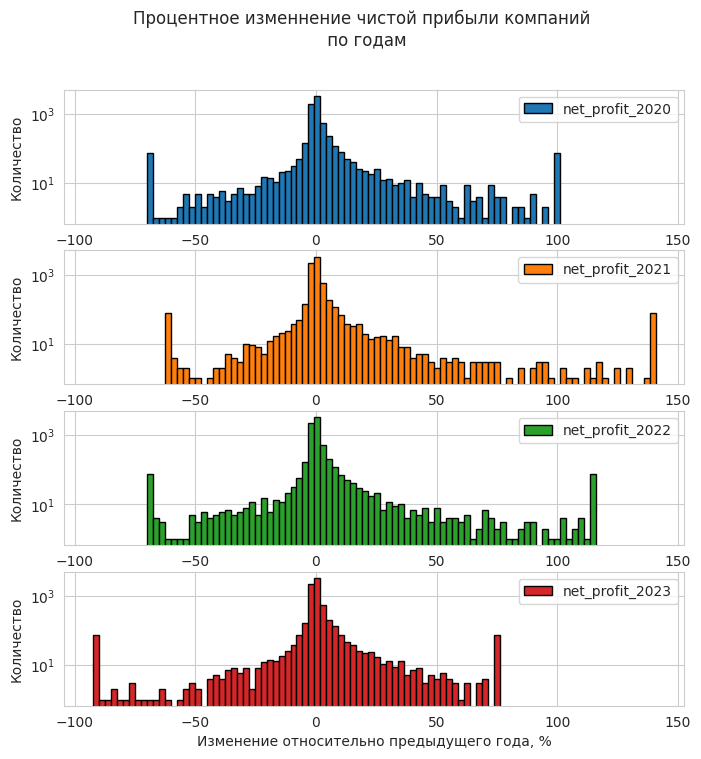

In [21]:
hist_plot(df_with_category, title="Процентное изменнение чистой прибыли компаний \n по годам")

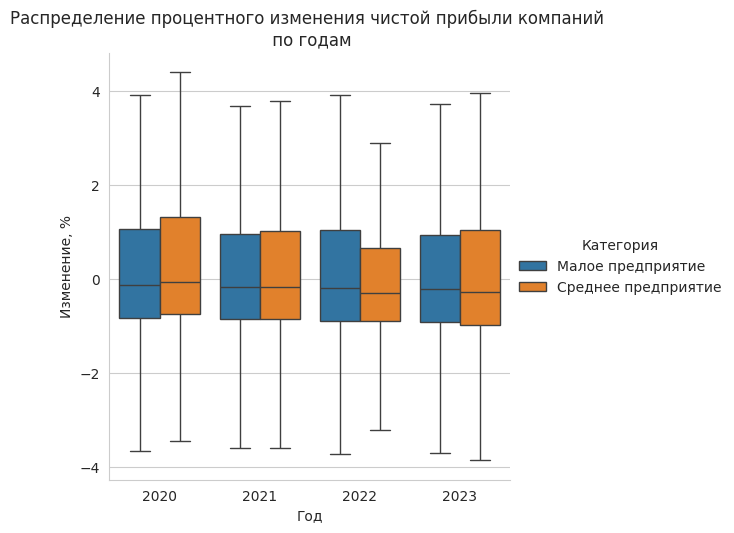

In [22]:
box_plot_with_cat(df_with_category, stubnames='net_profit_', title="Распределение процентного изменения чистой прибыли компаний \n по годам")

In [23]:
df_with_category.iloc[:, 2:].dropna(thresh=5).pct_change(axis=1).replace([np.inf, -np.inf], np.nan).iloc[:,1:].describe()

,net_profit_2020,net_profit_2021,net_profit_2022,net_profit_2023
count,7359.000000,7417.000000,7399.000000,7339.000000
mean,-14.963863,8.463444,25.059297,-4.039778
std,959.710623,837.751392,1775.513713,445.114401
min,-68094.500000,-24913.500000,-32855.000000,-14987.333333
25%,-0.816935,-0.859799,-0.885296,-0.924220
50%,-0.131727,-0.174756,-0.205586,-0.215264
75%,1.084706,0.963165,0.976823,0.947025
max,6004.400000,60478.000000,139037.733333,27345.666667


Здесь мы видим, что чистая прибыль как падала уже в 2020 году, так и продолжает падать. С учетом годовой инфляции картина становится еще печальнее.

Статистический тест:

In [24]:
test_data = df_with_category.iloc[:,2:].dropna(thresh=5)\
                                       .pct_change(axis=1)\
                                       .replace([np.inf, -np.inf], np.nan).iloc[:,1:]

In [25]:
alpha = 0.05
alpha_bonferroni = alpha / (test_data.shape[1] - 1)
print(f'Статистически значимая разница на уровне значимости {alpha_bonferroni:.1%}:')
for start_year, end_year in zip(test_data.columns[:-1], test_data.columns[1:]):
    t_stat, p_val = mannwhitneyu(test_data[start_year].dropna(), test_data[end_year].dropna())
    print([f'между {start_year.split("_")[-1]} и {end_year.split("_")[-1]} годами',\
           f'между {start_year.split("_")[-1]} и {end_year.split("_")[-1]} годами не'][bool(p_val > alpha_bonferroni)],
           f'обнаружена, p-value: {p_val:.3f}')

Статистически значимая разница на уровне значимости 1.7%:
между 2020 и 2021 годами не обнаружена, p-value: 0.040
между 2021 и 2022 годами не обнаружена, p-value: 0.129
между 2022 и 2023 годами не обнаружена, p-value: 0.391


Тест Манна - Уитни говорит нам о том, что значимого изменения динамики падения чистой прибыли компаний не наблюдается. Хотя, применяя менее консервативную поправку, мы скорее всего, увидели бы падение в 2021 году

### Дополнительно проведем небольшой когортный анализ компаний по их количеству и медианной чистой выручке

In [223]:
#преобразуем датасет из широкого в длинный
data_wide = pd.wide_to_long(df_with_category, stubnames='net_profit_', i=['id', 'Категория'], j='Год').reset_index()

In [234]:
# определим год, когда компания впервые подала данные о выручке в рамках имеющейся у на статистики
df_company_min_year = data_wide[data_wide['net_profit_'].notna()].groupby('id', as_index=False)['Год'].min().rename(columns={'Год': 'cohort'}).astype({'cohort': 'str'})

In [241]:
# построим сводные таблицы
data_wide.merge(df_company_min_year, how='left', on='id').pivot_table(index='cohort', columns='Год', values='net_profit_', aggfunc='count', margins=True).replace(0, '')

Год,2019,2020,2021,2022,2023,All
cohort,,,,,,
2019,7966,7941,7926,7862,7515,39210
2020,,255,246,243,215,959
2021,,,234,226,200,660
2022,,,,385,283,668
2023,,,,,16,16
All,7966,8196,8406,8716,8229,41513


In [240]:
data_wide.merge(df_company_min_year, how='left', on='id').pivot_table(index='cohort', columns='Год', values='net_profit_', aggfunc='median', margins=True).replace(np.nan, '')

Год,2019,2020,2021,2022,2023,All
cohort,,,,,,
2019,1971.5,2104.0,2043.5,1943.5,1984.0,2005.0
2020,,937.0,998.5,855.0,890.0,937.0
2021,,,679.0,1901.5,1440.0,1345.5
2022,,,,318.0,2777.0,809.0
2023,,,,,87.5,87.5
All,1971.5,2069.5,1959.0,1783.5,1940.0,1949.0
